# Mounting google drive : 
The trained model weights will be saved here.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Train and test data loaders

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
! pip install albumentations==0.4.6

In [4]:
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from data_loader import get_train_test_data_loaders
batch_size = 128
train_loader, test_loader, classes = get_train_test_data_loaders(random_seed=1,batch_size =batch_size)

CUDA Available? True


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   car horse   dog


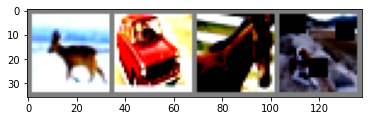

In [5]:
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from resnet import ResNet18
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device: ",device)
model = ResNet18().to(device)

device:  cuda


In [7]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Finding the best learning rate


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.82E-02


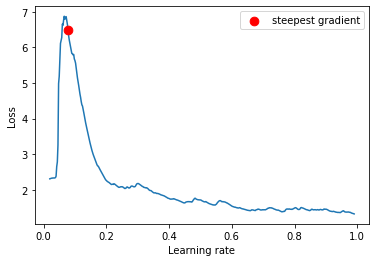

In [ ]:
from lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, nesterov=True)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=500, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

# Training the model

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from cifar10_trainer import ModelTrainer
import torch.nn.functional as F
import torch.nn as nn

criterion = nn.CrossEntropyLoss()


root_path = r"/content/gdrive/MyDrive/EVA5/S10AssignmentSolution"

EPOCHS = 50
train_test_history ={}

model = ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=8.42E-02, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose = True)
model_trainer = ModelTrainer()
  
for epoch in range(1,EPOCHS+1):
  print("EPOCH:", epoch)
  train_loss = model_trainer.train(model, device, train_loader, optimizer, epoch, criterion, l1_penalty=0)
  test_loss = model_trainer.test(model, device, test_loader, criterion)
  scheduler.step(test_loss)

  train_test_history[epoch] = {
      "train_losses": model_trainer.train_losses,
      "test_losses": model_trainer.test_losses,
      "train_accuracies": model_trainer.train_acc,
      "test_accuracies": model_trainer.test_acc
  }
  # save model weights after every 50 epochs
  if epoch%10 == 0:
    model_file_name = f"cifar_10_epoch_{epoch}.pth"
    model_path =f"{root_path}/{model_file_name}"
    torch.save(model.state_dict(), model_path)
    print(f"Saving the model for at {model_path}.")

EPOCH: 1
Train set: Average loss: 0.0159, Accuracy: 13316/50000 (26.63%)
Test set: Average loss: 0.0120, Accuracy: 4370/10000 (43.70%)
EPOCH: 2
Train set: Average loss: 0.0115, Accuracy: 23295/50000 (46.59%)
Test set: Average loss: 0.0100, Accuracy: 5476/10000 (54.76%)
EPOCH: 3
Train set: Average loss: 0.0094, Accuracy: 28612/50000 (57.22%)
Test set: Average loss: 0.0080, Accuracy: 6383/10000 (63.83%)
EPOCH: 4
Train set: Average loss: 0.0079, Accuracy: 32086/50000 (64.17%)
Test set: Average loss: 0.0075, Accuracy: 6633/10000 (66.33%)
EPOCH: 5
Train set: Average loss: 0.0068, Accuracy: 34660/50000 (69.32%)
Test set: Average loss: 0.0058, Accuracy: 7421/10000 (74.21%)
EPOCH: 6
Train set: Average loss: 0.0059, Accuracy: 36810/50000 (73.62%)
Test set: Average loss: 0.0052, Accuracy: 7688/10000 (76.88%)
EPOCH: 7
Train set: Average loss: 0.0052, Accuracy: 38248/50000 (76.50%)
Test set: Average loss: 0.0048, Accuracy: 7921/10000 (79.21%)
EPOCH: 8
Train set: Average loss: 0.0047, Accuracy: 394

In [ ]:
import json

with open(f"{root_path}/train_test_metrics.json", "w") as outfile:  
    json.dump(train_test_history, outfile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


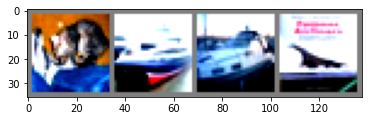

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
# images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

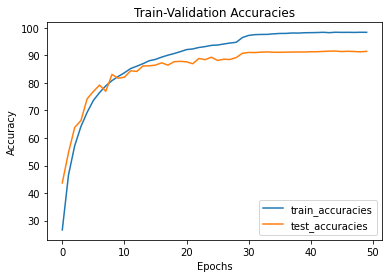

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_test_history[50]["train_accuracies"],label="train_accuracies")
ax.plot(train_test_history[50]["test_accuracies"],label="test_accuracies")
leg = ax.legend()
  
plt.title('Train-Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(f'{root_path}/accuracy_plot.png')

# Measuring classwise accuracies

In [ ]:
model = ResNet18().to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/EVA5/S10AssignmentSolution/cifar_10_epoch_50.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 88 %
Accuracy of   cat : 82 %
Accuracy of  deer : 91 %
Accuracy of   dog : 84 %
Accuracy of  frog : 95 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


# GradCam

In [8]:
model = ResNet18().to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/EVA5/S10AssignmentSolution/cifar_10_epoch_50.pth"))

<All keys matched successfully>

In [9]:
from gradcam import get_gradcam_results
import cv2

In [10]:
image_label_prediction_list = []
count = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(images.shape[0]):
            if c[i].item() == False:
              image, label, prediction = images[i], labels[i].item(), predicted[i].item()
              image_label_prediction_list.append(
                  (image, label, prediction)
              )
              if count == 25:
                break
              count += 1

        if count == 25:
              break
           

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


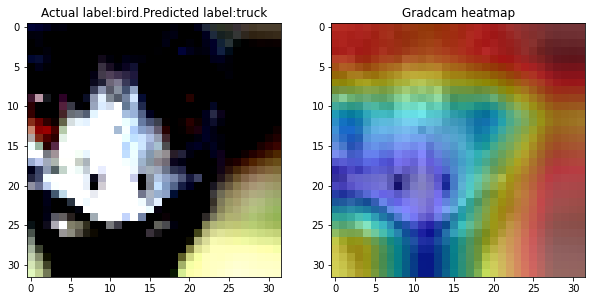

In [56]:
image, label_id, prediction_id = image_label_prediction_list[0]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


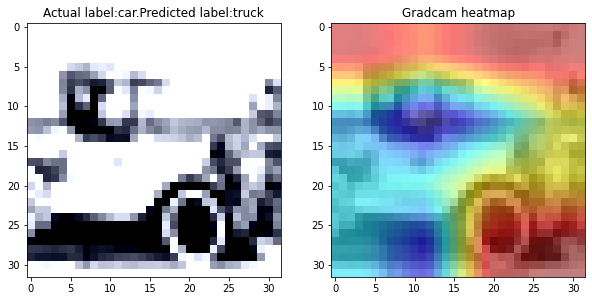

In [57]:
image, label_id, prediction_id = image_label_prediction_list[1]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


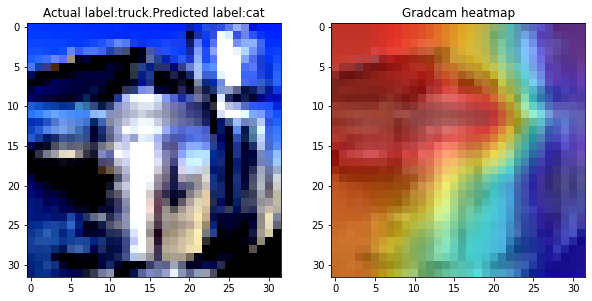

In [58]:
image, label_id, prediction_id = image_label_prediction_list[2]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


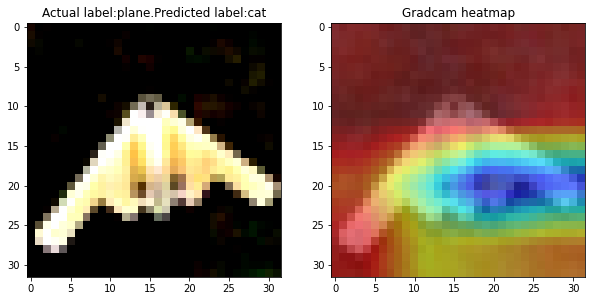

In [59]:
image, label_id, prediction_id = image_label_prediction_list[3]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


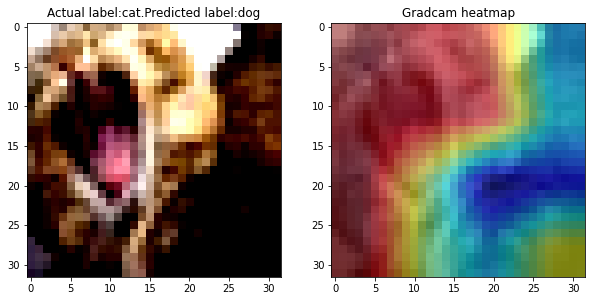

In [60]:
image, label_id, prediction_id = image_label_prediction_list[4]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


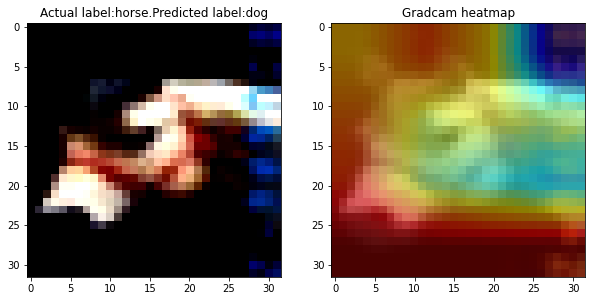

In [61]:
image, label_id, prediction_id = image_label_prediction_list[5]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


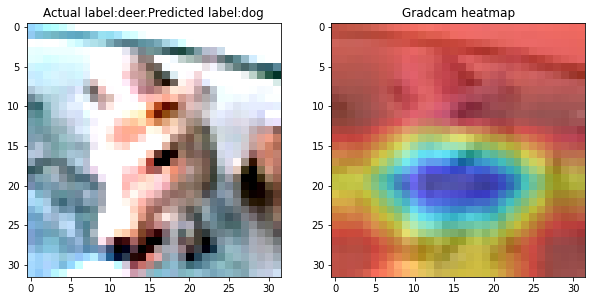

In [62]:
image, label_id, prediction_id = image_label_prediction_list[6]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


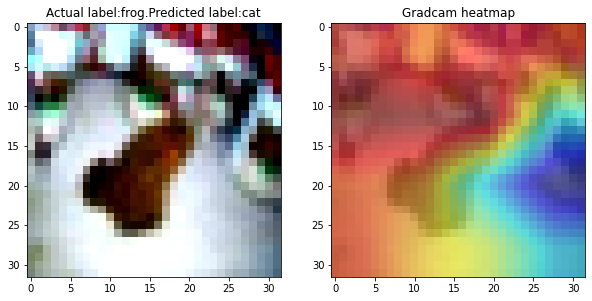

In [63]:
image, label_id, prediction_id = image_label_prediction_list[7]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


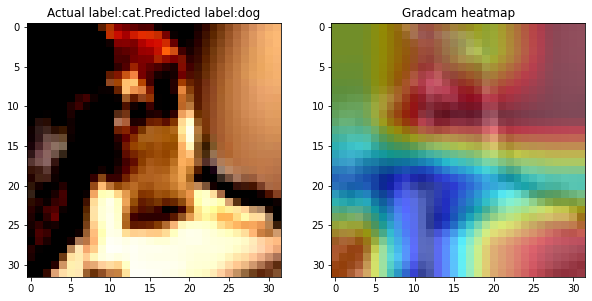

In [64]:
image, label_id, prediction_id = image_label_prediction_list[8]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


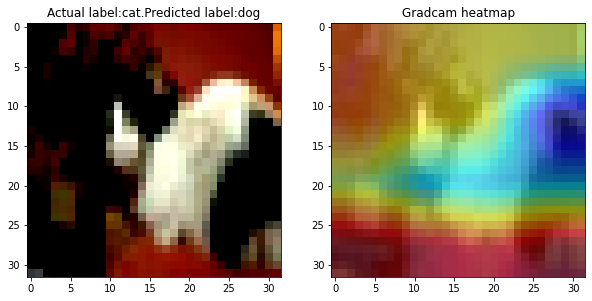

In [65]:
image, label_id, prediction_id = image_label_prediction_list[9]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


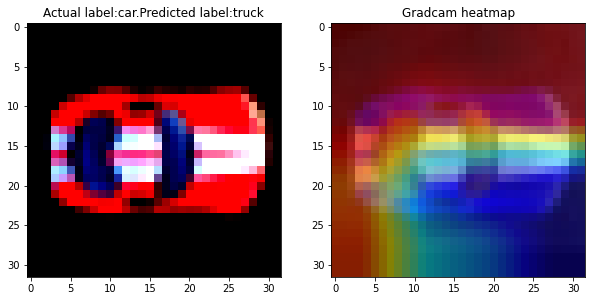

In [66]:
image, label_id, prediction_id = image_label_prediction_list[10]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


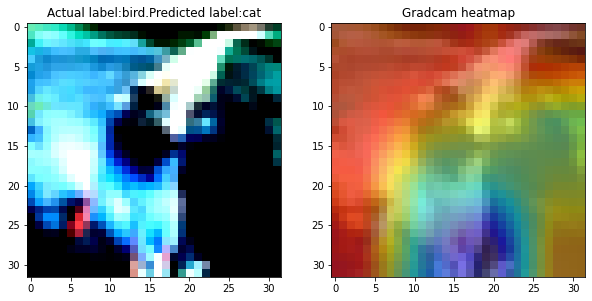

In [67]:
image, label_id, prediction_id = image_label_prediction_list[11]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


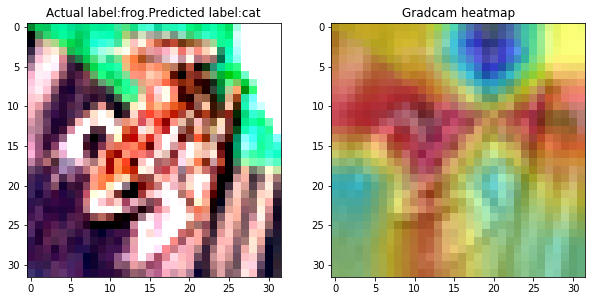

In [68]:
image, label_id, prediction_id = image_label_prediction_list[12]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


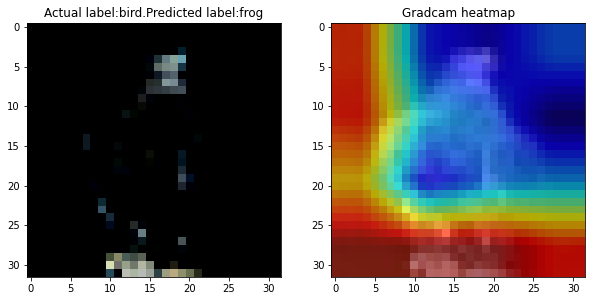

In [69]:
image, label_id, prediction_id = image_label_prediction_list[13]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


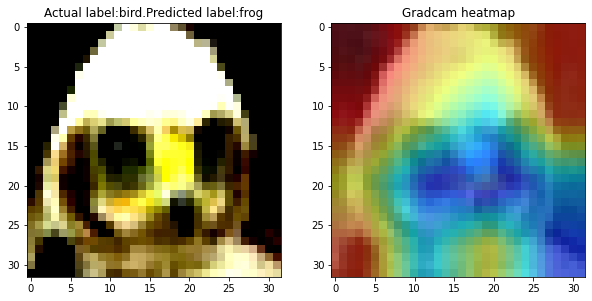

In [70]:
image, label_id, prediction_id = image_label_prediction_list[14]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


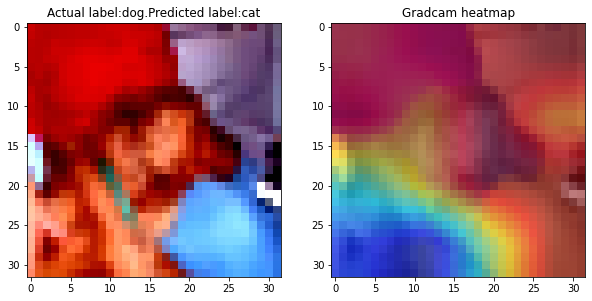

In [71]:
image, label_id, prediction_id = image_label_prediction_list[15]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


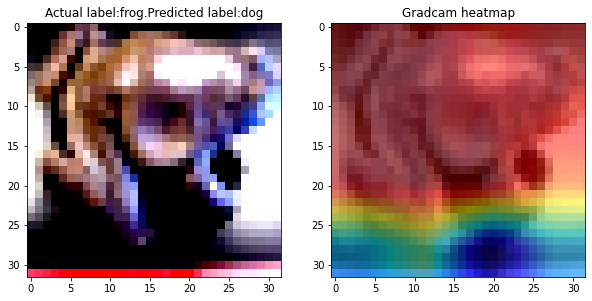

In [72]:
image, label_id, prediction_id = image_label_prediction_list[16]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


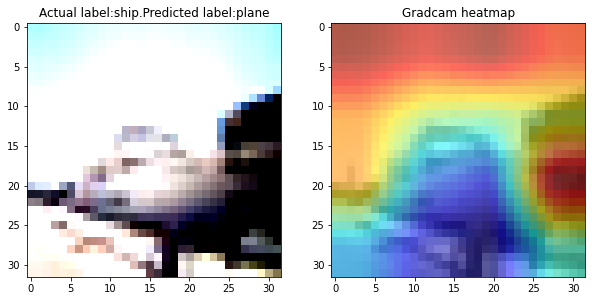

In [73]:
image, label_id, prediction_id = image_label_prediction_list[17]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


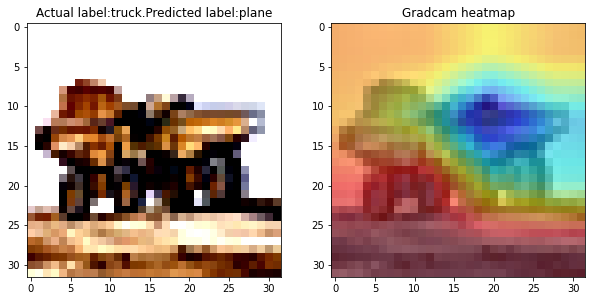

In [74]:
image, label_id, prediction_id = image_label_prediction_list[18]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


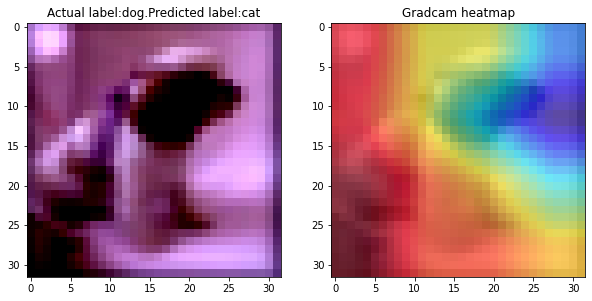

In [75]:
image, label_id, prediction_id = image_label_prediction_list[19]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


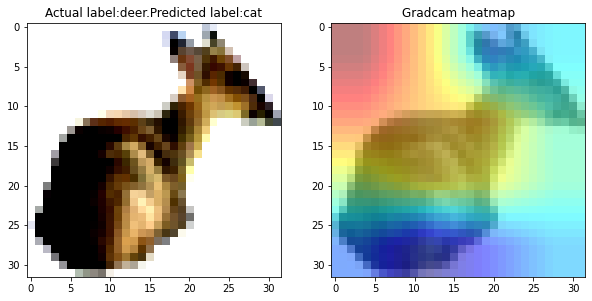

In [76]:
image, label_id, prediction_id = image_label_prediction_list[20]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


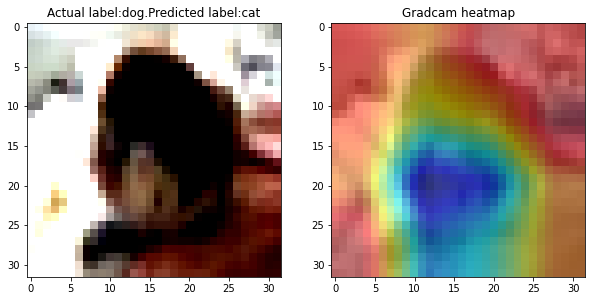

In [77]:
image, label_id, prediction_id = image_label_prediction_list[21]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


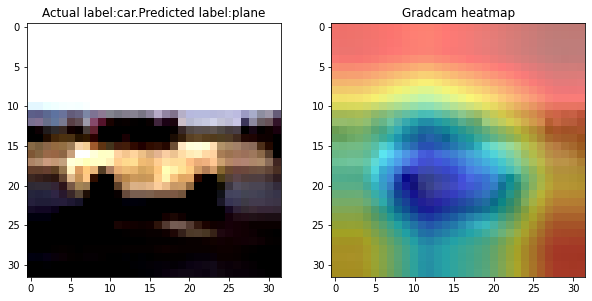

In [78]:
image, label_id, prediction_id = image_label_prediction_list[22]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


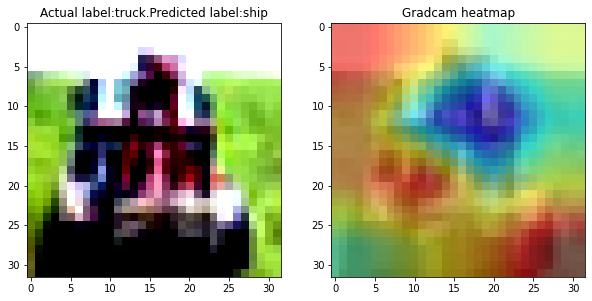

In [79]:
image, label_id, prediction_id = image_label_prediction_list[23]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


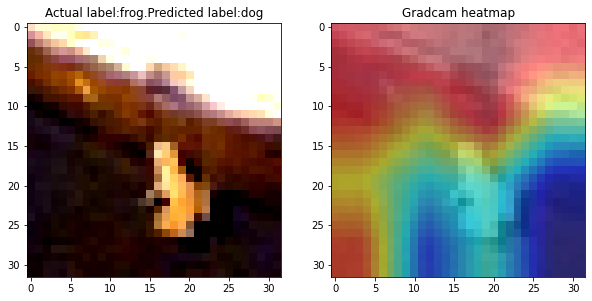

In [80]:
image, label_id, prediction_id = image_label_prediction_list[24]
image = image.to("cpu").numpy()
image = np.transpose(image, (1, 2, 0))
img_input2plot = image / 2 + 0.5 
img_original = np.clip((0.2*image + 0.5)*255, 0,255) 
outputs = get_gradcam_results(model,model.layer4,["1"],img_original,True)
fig=plt.figure(figsize=(10, 10))
columns, rows = 2,1
h,w=10,10
img_list = [img_input2plot,outputs[0]]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
    if i == 1:
      plt.title(f"Actual label:{classes[label_id]}.Predicted label:{classes[prediction_id]}")
    else:
      plt.title("Gradcam heatmap")
plt.show()